In [8]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

c:\users\vislab_phy\anaconda3\envs\py37\python.exe
3.7.0 (default, Jun 28 2018, 08:04:48) [MSC v.1912 64 bit (AMD64)]
sys.version_info(major=3, minor=7, micro=0, releaselevel='final', serial=0)


In [3]:
# DATA 준비
# 20201008
#---- to do list -----
# err_data_list 파일자동화

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

from tensorflow.python.keras.optimizer_v2.rmsprop import RMSProp
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv, DataFrame, concat
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, RepeatVector, LSTM, Input, TimeDistributed, Activation, Dropout
from keras.optimizers import SGD
np.set_printoptions(suppress=True)

#pow 낮값만 추출 test
#pow = 0인 구간 : 0~4, 21-23시
powhr_start = 5
powhr_end   = 20

shift_days  = 3
hoursteps   = powhr_end-powhr_start+1 #(16)
timesteps   = shift_days*hoursteps #hours step

data_dim    = 5
out_dim     = 1

n_model    = 10

season_mod = 'all_1030_f9'
date_start = '10190901'
date_end   = '30191201'

err_date_list = ['20190912',
                    '20191122',
                    '20191130',
                    '20191217',
                    '20200501',
                    '20200502',
                    '20191028',
                    '20191107',
                    '20191108',
                    '20191109',
                    '20191110',
                    '20191111',
                    '20191112',
                    '20200214',
                    '20200307',
                    '20200308',
                    '20200309',
                    '20200310',
                    '20200328',
                    '20200329',
                    '20200625',
                    '20200809']

Using TensorFlow backend.


# Get weather, pow data

In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import fnmatch
from pandas import read_csv

#############################################
# 태양광 전력
#############################################
def get_pow():

    # pow 파일 load
    dir_path    = "C:/Users/VISLAB_PHY/Desktop/WORKSPACE/Origin/data/pow_24/UR00000126_csv"
    file_list   = os.listdir(dir_path)
    print(len(file_list))
    hrPow  = []    

    # pow측정값 에러가 큰 일자 제거
    for filename in file_list:
        if (filename[:-4] not in err_date_list):
            if ((filename[:-4]>=date_start) & (filename<date_end)):
                filedata = pd.read_csv(dir_path+'/'+filename).values[:,0]
                hrPow.append(filedata)
                
    #낮시간 추출 (5~20시)
    pow_dataset = pd.DataFrame(hrPow)
    pow_dataset =pow_dataset.iloc[:,powhr_start:powhr_end+1]
    pow_dataset.to_csv("C:/Users/VISLAB_PHY/Desktop/WORKSPACE/Origin/data/pow_hr.csv",mode='w',index=False)

    # 결측값 보간, reshape
    pow_dataset = pow_dataset.interpolate(method='linear')
    pow_dataset = pow_dataset.values.reshape(-1,1)
    pow_dataset = pd.DataFrame(pow_dataset)
    pow_dataset.columns = ['pow']
    pow_dataset.to_csv("C:/Users/VISLAB_PHY/Desktop/WORKSPACE/Origin/data/pow2.csv",mode='w',index=False)

    
    # scale
    sc_pow = MinMaxScaler(feature_range = (0, 1))
    scaled_pow = sc_pow.fit_transform(pow_dataset.values)
    df_pow = pd.DataFrame(scaled_pow, columns=pow_dataset.columns, index=list(pow_dataset.index.values))
    
    return df_pow, sc_pow

#############################################
# 종관기상관측
#############################################
def get_weather():
    # pow 파일 load
    dir_path    = "C:/Users/VISLAB_PHY/Desktop/WORKSPACE/Origin/DATA"
    file_list   = os.listdir(dir_path)
    print(len(file_list))
    for filename in os.listdir(dir_path):
        if fnmatch.fnmatch(filename, 'OBS_ASOS_TIM_*.csv'):
            print(filename)

            # load csv data
            dataset = read_csv(dir_path+'/'+filename, encoding='CP949')
            dataset.drop(['지점','지점명'], axis=1, inplace=True)
            dataset.drop(['기온 QC플래그','강수량 QC플래그','풍속 QC플래그','풍향 QC플래그','습도 QC플래그'], axis=1, inplace=True)
            dataset.drop(['현지기압 QC플래그','해면기압 QC플래그','일조 QC플래그','지면온도 QC플래그'], axis=1, inplace=True)
            dataset.drop(['5cm 지중온도(°C)','10cm 지중온도(°C)','20cm 지중온도(°C)','30cm 지중온도(°C)'], axis=1, inplace=True)
            dataset.drop(['3시간신적설(cm)','일사(MJ/m2)','운형(운형약어)','지면상태(지면상태코드)','현상번호(국내식)'], axis=1, inplace=True)

            # set column name
            dataset.columns = ['ymdhms', 'temprt', 'rain', 'wnd_spd', 'wnd_dir', 'humdt','steampressr',
                               'dewpnt', 'pressr','seapressr','sunshine','snow','cloud','cloud2','mincloud','visiblt','grd_temprt']

            # prioirty sort (피어슨상관계수)
            dataset = dataset[['ymdhms','sunshine','humdt','wnd_spd','visiblt','grd_temprt',
                               'cloud2','wnd_dir','cloud','dewpnt','steampressr','temprt',
                               'mincloud','rain','pressr','seapressr','snow']]


            # set NA data (관측값 0이 누적되어 결측된 경우. 0으로 세팅)
            dataset['rain'].fillna(0, inplace=True)     #강수량
            dataset['sunshine'].fillna(0, inplace=True) #일조
            dataset['snow'].fillna(0, inplace=True)     #적설량

            #일시 패턴 변환(2019-08-20 5:00 -> 2019082005)
            dataset['ymdhms'] = dataset['ymdhms'].str[0:4]+dataset['ymdhms'].str[5:7]+dataset['ymdhms'].str[8:10]+dataset['ymdhms'].str[11:13]
            # pow측정값 중 결측값 많은 일자 제거
            dataset = dataset[(dataset['ymdhms'].str[0:8]>=date_start) & (dataset['ymdhms'].str[0:8]<date_end)]
            for err_date in err_date_list:
                idx_err = dataset[dataset['ymdhms'].str.startswith(err_date)].index
                dataset = dataset.drop(idx_err)

            #낮시간 추출 (5~20시)
            dataset = dataset[(dataset['ymdhms'].str[-2:]>=str(powhr_start).rjust(2, '0')) &(dataset['ymdhms'].str[-2:]<=str(powhr_end))]
            dataset = dataset.iloc[:, 0:data_dim] #feature size 조절
            dataset = dataset.interpolate(method='linear')# 결측값 보간
            
            # save file (test용)
            dataset.to_csv("C:/Users/VISLAB_PHY/Desktop/WORKSPACE/Origin/DATA/weather2.csv",mode='w',index=False)

            # normalization
            dataset.drop(['ymdhms'], axis=1, inplace=True)
            dataset = dataset.astype('float32')
            dataset = dataset.interpolate(method='linear')
            
            sc = MinMaxScaler(feature_range = (0, 1))#scale
            scaled_weather = sc.fit_transform(dataset.values)
            weather = pd.DataFrame(scaled_weather, columns=dataset.columns, index=list(dataset.index.values))
            
    return weather

#############################################
# numpy data 만들기
#############################################
# load weather, pow dataset

df_pow, sc_pow   = get_pow()
df               = get_weather()

df.insert(0, 'pow', df_pow.values, True)
print("******************************************* test ")
df.insert(1, 'root_pow', df['pow']**(1/2), True)
df.insert(1, 'log_pow', np.log1p(df['pow']), True)
df.insert(4, 'temp_press', df['temprt'] - df['steampressr'], True)
df.insert(4, 'sunshine_humdt', abs(df['sunshine']) - (df['humdt']*0.35), True)


df.to_csv("C:/Users/VISLAB_PHY/Desktop/WORKSPACE/Origin/data/dataset_p2.csv",mode='w',index=False, encoding='CP949')

337
18
OBS_ASOS_TIM_20200929025447.csv
******************************************* test 


### pow transformation- correlation

In [95]:
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
corr = df.corr(method = 'pearson') 

#display(corr.iloc[:,0:2])
display_side_by_side(corr.iloc[3:,0:1],corr.iloc[3:,1:2],corr.iloc[3:,2:3])

pow 
 
 
 
 
 sunshine 
 0.687319 
 
 
 sunshine_humdt 
 0.693599 
 
 
 temp_press 
 0.557151 
 
 
 humdt 
 -0.544562 
 
 
 wnd_spd 
 0.386582 
 
 
 visiblt 
 0.343840 
 
 
 grd_temprt 
 0.253527 
 
 
 cloud2 
 -0.334067 
 
 
 wnd_dir 
 0.250018 
 
 
 cloud 
 -0.350742 
 
 
 dewpnt 
 -0.219610 
 
 
 steampressr 
 -0.221819 
 
 
 temprt 
 0.098566 
 
 
 mincloud 
 0.193947 
 
 
 rain 
 -0.122264 
 
 
 pressr 
 0.087202 
 
 
 
 
 
 
 log_pow 
 
 
 
 
 sunshine 
 0.711112 
 
 
 sunshine_humdt 
 0.715260 
 
 
 temp_press 
 0.561601 
 
 
 humdt 
 -0.550353 
 
 
 wnd_spd 
 0.387495 
 
 
 visiblt 
 0.355640 
 
 
 grd_temprt 
 0.267869 
 
 
 cloud2 
 -0.338519 
 
 
 wnd_dir 
 0.254955 
 
 
 cloud 
 -0.347133 
 
 
 dewpnt 
 -0.208824 
 
 
 steampressr 
 -0.211778 
 
 
 temprt 
 0.112584 
 
 
 mincloud 
 0.192078 
 
 
 rain 
 -0.130335 
 
 
 pressr 
 0.086951 
 
 
 
 
 
 
 root_pow 
 
 
 
 
 sunshine 
 0.719817 
 
 
 sunshine_humdt 
 0.717306 
 
 
 temp_press 
 0.534966 
 
 
 humdt 
 -0.519771 
 
 
 wnd_spd 
 0.369771 
 
 
 visiblt 
 0.355962 
 
 
 grd_temprt 
 0.319582 
 
 
 cloud2 
 -0.298668 
 
 
 wnd_dir 
 0.241335 
 
 
 cloud 
 -0.286645 
 
 
 dewpnt 
 -0.141388 
 
 
 steampressr 
 -0.144869 
 
 
 temprt 
 0.170937 
 
 
 mincloud 
 0.162137 
 
 
 rain 
 -0.139327 
 
 
 pressr 
 0.045782

In [100]:
df = df.iloc[:, :2+data_dim] #feature size 조절
print(df)

           pow   log_pow  root_pow  sunshine  sunshine_humdt  temp_press  \
5     0.000000  0.000000  0.000000       0.0       -0.346023    0.029743   
6     0.016185  0.016055  0.127220       0.0       -0.346023    0.034361   
7     0.078613  0.075676  0.280380       0.0       -0.346023    0.026165   
8     0.194798  0.177977  0.441359       0.4        0.089773    0.038087   
9     0.245087  0.219205  0.495062       0.7        0.437500    0.090804   
...        ...       ...       ...       ...             ...         ...   
8512  0.013873  0.013777  0.117783       0.0       -0.302273   -0.042837   
8513  0.015607  0.015486  0.124928       0.0       -0.330114   -0.090144   
8514  0.010983  0.010923  0.104798       0.0       -0.314205   -0.050909   
8515  0.000000  0.000000  0.000000       0.0       -0.330114   -0.064577   
8516  0.000000  0.000000  0.000000       0.0       -0.342045   -0.077268   

         humdt   wnd_spd   visiblt  grd_temprt  cloud2   wnd_dir  cloud  \
5     0.9886

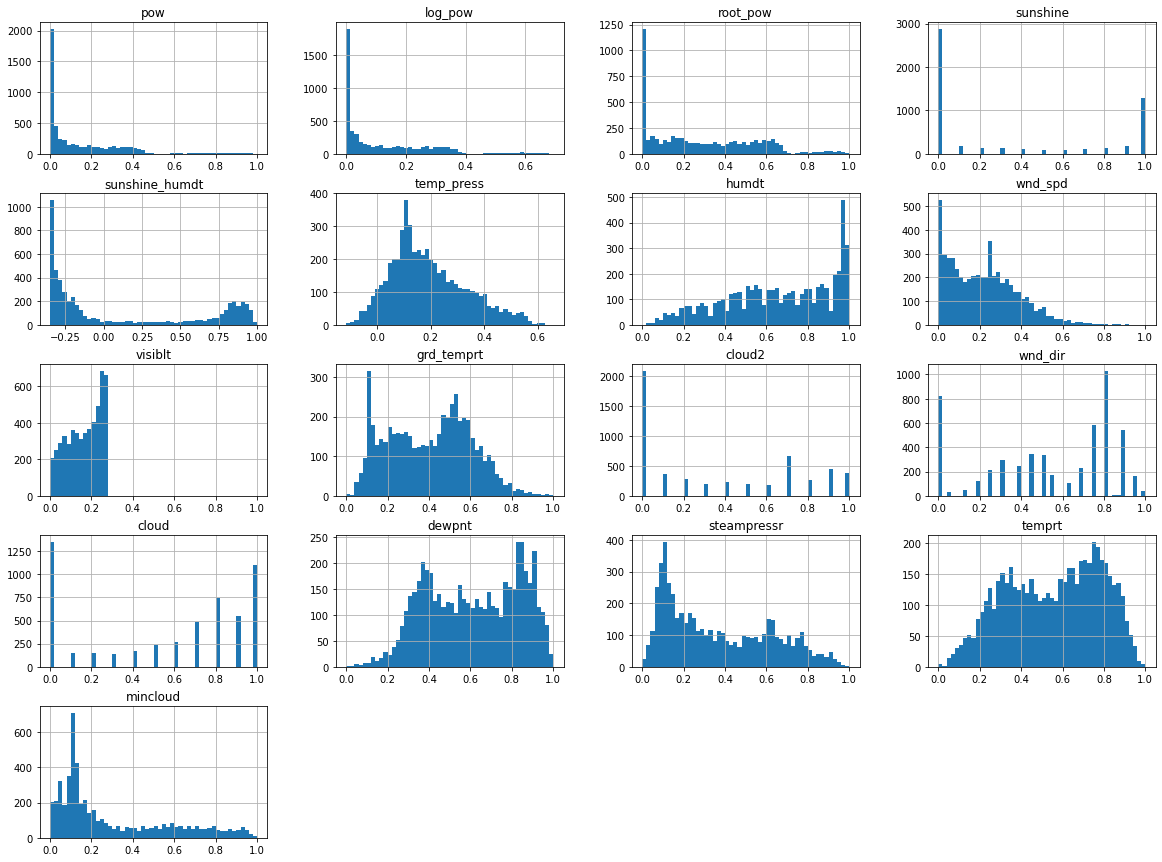

In [101]:
df.hist(bins=50, figsize=(20, 15))
plt.show()

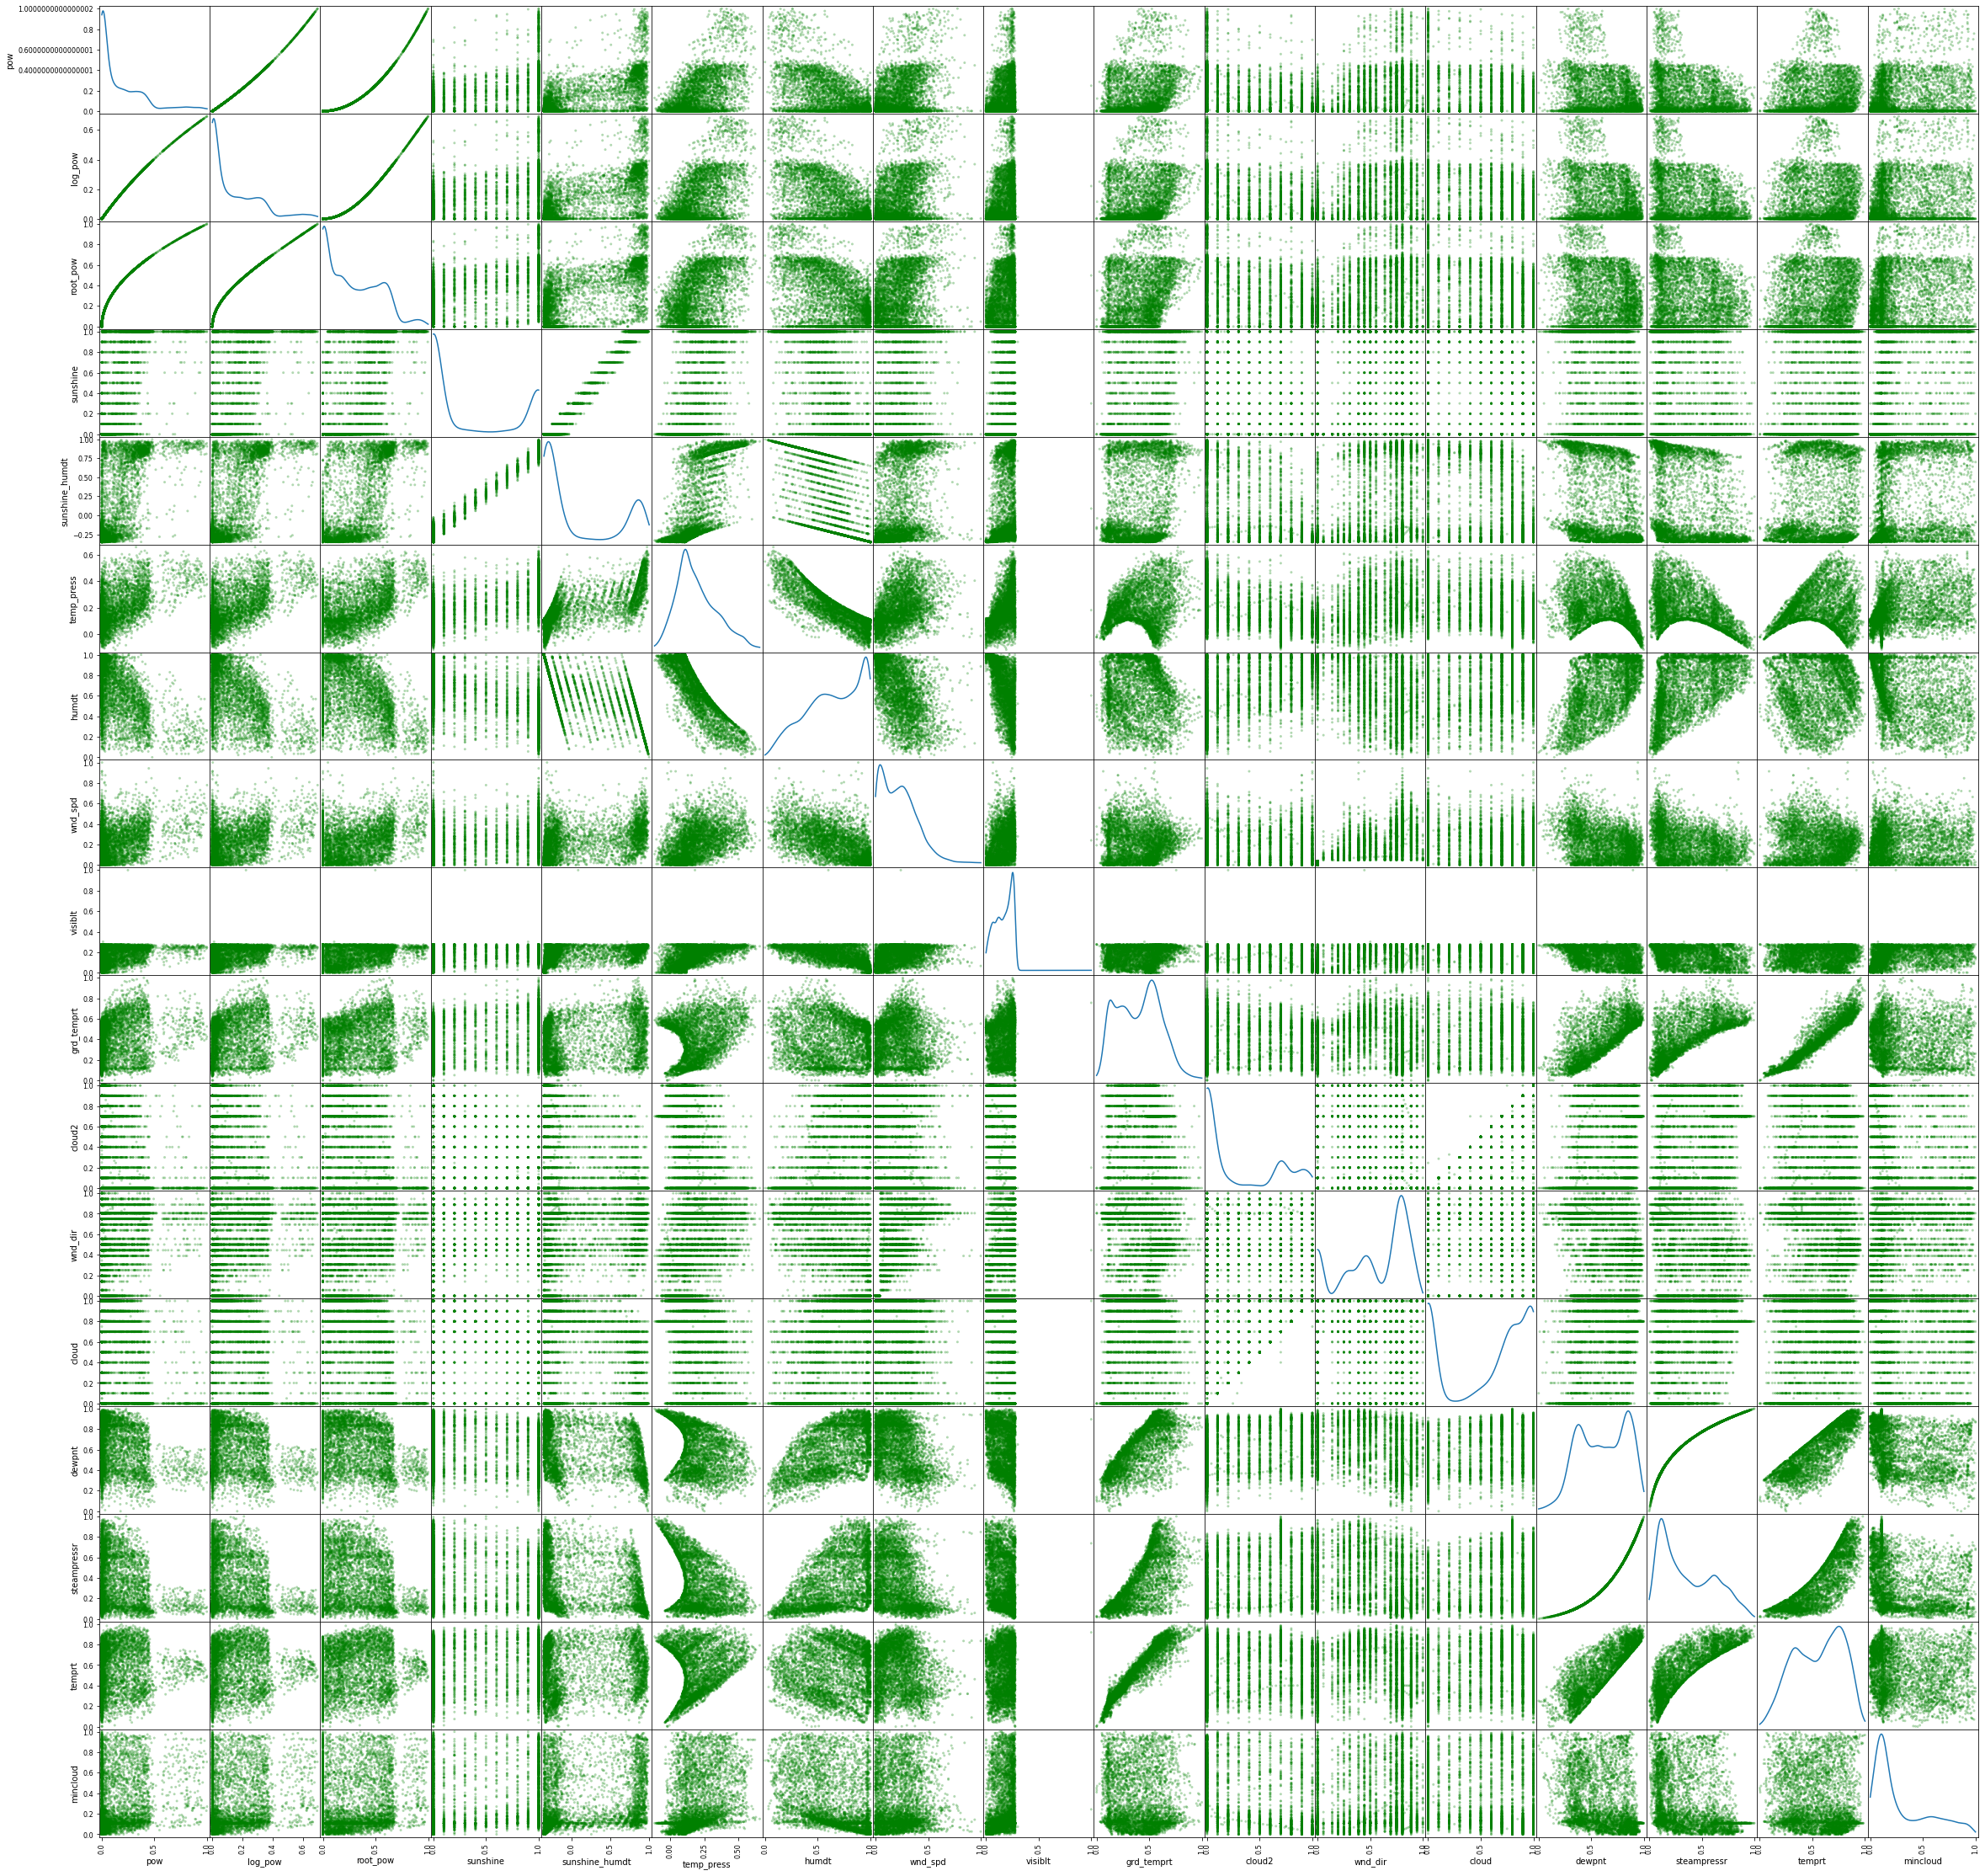

In [102]:
from pandas.plotting import scatter_matrix

scatter_matrix(df, diagonal='kde', color='g', alpha=0.3, figsize=(40, 40))
plt.show()

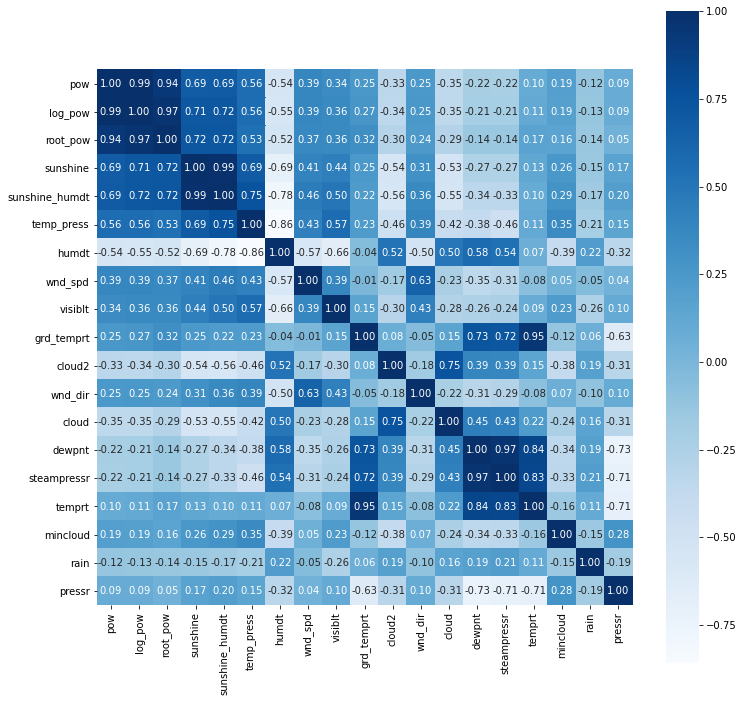

In [103]:
import matplotlib.pyplot as plt 
import seaborn as sns

fig, ax = plt.subplots(figsize=(12,12))  
df_heatmap = sns.heatmap(corr, cbar = True, annot = True, annot_kws={'size' : 10}, fmt = '.2f', square = True, cmap = 'Blues')
